In [ ]:
'''
author: 梁泽涛，叶文涛
create time: 2020-7-16
update time: 2020-7-19
'''

In [1]:
import numpy as np
import pandas as pd

import lightgbm as lgb

import os,gc,time,re,datetime
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold,StratifiedKFold,GroupKFold
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# from pipeline.util import *
# from pipeline.preprocess import *
# from pipeline.config import *

In [2]:
%time train_data = pd.read_pickle('data/clean_data1.pkl')

Wall time: 12.4 s


In [3]:
train_data.loc[train_data.direction==36000,'direction'] = 0
# 删除速度大于60， 方向小于0/大于36000的异常数据
train_data = train_data[~((train_data.speed>60)|(train_data.direction<0)|(train_data.direction>36000))].reset_index(drop=True)

In [4]:
test_data = pd.read_csv('./data/R2 ATest 0711.csv')
port_df = pd.read_csv('./data/port.csv')

test_data.drop_duplicates(inplace=True)
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'],infer_datetime_format=True).apply(lambda x: x.replace(tzinfo=None))
test_data['onboardDate'] = pd.to_datetime(test_data['onboardDate'],infer_datetime_format=True).apply(lambda x: x.replace(tzinfo=None))

test_data = test_data.sort_values(by=['loadingOrder','timestamp']).reset_index(drop=True)

test_data.loc[test_data.TRANSPORT_TRACE=='HUNGARY-HON','TRANSPORT_TRACE'] = 'SIKOP-HKHKG'
#test_data.loc[test_data.vesselMMSI=='R3419973056','vesselMMSI'] = 'W2722004813'
#test_data.loc[test_data.vesselMMSI=='X2692921717','vesselMMSI'] = 'Z8556231115'

port_df.drop(columns=['STATE','CITY','REGION','ADDRESS','PORT_CODE','TRANSPORT_NODE_ID'],inplace=True)
port_df.COUNTRY = port_df.COUNTRY.str.lower()

In [5]:
port_dict = {}
for idx,row in port_df.iterrows():
    port_dict[row['TRANS_NODE_NAME']] = [row['LONGITUDE'],row['LATITUDE']]

In [9]:
# haversine 经纬度球面距离
def Distance(LonA,LatA,LonB,LatB):
    EARTH_RADIUS = 6378.137 # 千米
    radLatA = np.radians(LatA)
    radLatB = np.radians(LatB)
    a = radLatA-radLatB
    b = np.radians(LonA)-np.radians(LonB)
    s= 2 * np.arcsin(np.sqrt(np.power(np.sin(a / 2),2)+ np.cos(radLatA) * np.cos(radLatB)*np.power(np.sin(b / 2),2))) * EARTH_RADIUS
    return s  

def get_arrival_time(df,end_port):
    
    # 监控end_time的list，无实际作用
    end_time_lst = []
    
    df.reset_index(drop=True,inplace=True)

    end_port_coord = port_dict[end_port]
    
    
    # 选取靠近终点港口的记录
    near_end_port_df = df[np.sqrt((df.longitude-end_port_coord[0])**2+(df.latitude-end_port_coord[1])**2)<0.4]
    if len(near_end_port_df)<=0:
        print('error 0，未靠近终点港口')
        return 0
    
    # 取靠近终点港口的记录的第一点
    end_time = near_end_port_df.timestamp.values[0]
    end_time_lst.append(end_time)
    # 取近港无0速度的 0.1分位点
    min_speed_near_end = near_end_port_df.speed[near_end_port_df.speed!=0].quantile(0.1)
    
    # 尝试获取近港速度中小于0.1分位点的速度中的首位
    if min_speed_near_end>=0:
        end_time = near_end_port_df[near_end_port_df.speed<=min_speed_near_end].timestamp.values[0]
        
    end_time_lst.append(end_time)
    
    # 在靠近终点港口的记录中选取状态为moored的
    end_moored_df = near_end_port_df[near_end_port_df.vesselStatus=='moored']
    if len(end_moored_df)>0:
        end_time_idx = end_moored_df.index[0]
        # 尝试获取moored状态改变前的值
        try:
            end_time = near_end_port_df.timestamp[end_time_idx-1]
        except:
            print('error 1, 状态改变')
    end_time_lst.append(end_time)
    
    # 近港时间间隔
    near_end_port_df['end_diff_hour'] = near_end_port_df.timestamp.diff(1).dt.total_seconds()/3600
    # 如果间隔时间大于6小时且为最大的，取该index
    end_time_idx_by_diff_hour = near_end_port_df.index[(near_end_port_df.end_diff_hour>6)&(near_end_port_df.end_diff_hour==near_end_port_df.end_diff_hour.max())]

    if len(end_time_idx_by_diff_hour)>0:
        # 尝试获取间隔时间大于6小时且为最大的间隔，的前5个点
        try:
            end_time_by_diff_hour = pd.to_datetime(near_end_port_df.timestamp[end_time_idx_by_diff_hour[0]-1]).tz_localize(None)
            end_time = min(pd.to_datetime(end_time).tz_localize(None),end_time_by_diff_hour)
        except:
            print('error 2， 时间间隔')
    
    end_time_lst.append(end_time)
    #print(list(map(str,end_time_lst)))
    # 选取最后的end_time
    end_time = pd.to_datetime(end_time_lst[-1]).tz_localize(None)

    return end_time 

'''
def get_arrival_time(df,end_port):

    df.reset_index(drop=True,inplace=True)

    end_port_coord = port_dict[end_port]
    
    # 选取靠近终点港口的记录
    near_end_port_df = df[np.sqrt((df.longitude-end_port_coord[0])**2+(df.latitude-end_port_coord[1])**2)<0.7]
    if len(near_end_port_df)<=0:
        return 0
    more_near_end_port_df = near_end_port_df[Distance(near_end_port_df['longitude'],near_end_port_df['latitude'],end_port_coord[0],end_port_coord[1])<=35]
    if len(more_near_end_port_df)<=0:
        return 0
    
    end_time = more_near_end_port_df.timestamp.values[0]
    
    end_time = pd.to_datetime(end_time).tz_localize(None)
    
    return end_time
'''

# 将时间裁剪到早于end_time的范围
def cut_time(df):
    global tmp_arrival_time
    order = df.loadingOrder.values[0]
    end_time = tmp_arrival_time[order]
    t = df.timestamp.apply(lambda x: x.replace(tzinfo=None))
    return df[t<=end_time]

def order_sample(df,alpha=0.5):
    '''
    训练集随机采样
    '''
    order = df.loadingOrder.values[0]
    # 采样点的数量
    '''sample_size = max(1,int(df.shape[0]**alpha))
    df = df.reset_index(drop=True)
    sample_idx = np.random.choice(np.arange(df.shape[0]),size=sample_size,replace=False)
    df = df.iloc[sample_idx].reset_index(drop=True)
    '''
    global tmp_arrival_time
    arrival_time = tmp_arrival_time[order]
    
    df['label'] = (arrival_time - df.timestamp.apply(lambda x: x.replace(tzinfo=None))).dt.total_seconds()
    
    return df

# 获取特征
def get_feature(df,end_port):
    
    def cut_trace(t,end_port):
        t = t.split('-')
        idx = t.index(end_port)
        return '-'.join(t[:idx+1])
    
    df['trace'] = df['TRANSPORT_TRACE'].apply(lambda x:cut_trace(x,end_port))
    df['trace_len'] = df['trace'].apply(lambda x:len(x.split('-')))
    
    end_p = port_dict[end_port]
    df['dist2end'] = Distance(df['longitude'],df['latitude'],end_p[0],end_p[1])
    df['end_port_long_sin'] = np.sin(np.radians(end_p[0]))
    df['end_port_long_cos'] = np.cos(np.radians(end_p[0]))
    df['end_port_lat'] = np.radians(end_p[1])
    
    df['long_sin'] = np.sin(np.radians(df['longitude']))
    df['long_cos'] = np.cos(np.radians(df['longitude']))
    df['lat'] = np.radians(df['latitude'])
    
    cols = ['loadingOrder','carrierName','timestamp','vesselMMSI','trace','trace_len',
            'dist2end',
            'long_sin','long_cos','lat','end_port_long_sin','end_port_long_cos','end_port_lat',
            'label']
    
    return df[cols]

In [7]:
# 将test_data的终点港口存入集合
end_port_set = set()
for trace in test_data.TRANSPORT_TRACE.unique():
    end_port_set.add(trace.split('-')[-1])

In [10]:
train_ft = []
for idx,end_port in enumerate(tqdm(end_port_set)):
    # 获取含有终点港口end_port的路由的数据
    # 且不能为起始港口
    tmp_data = train_data[train_data.TRANSPORT_TRACE.str.match(f'.*-{end_port}.*')].reset_index(drop=True)
    
    tmp_arrival_time = tmp_data.groupby(by='loadingOrder').apply(get_arrival_time,end_port)

    tmp_arrival_time = tmp_arrival_time[tmp_arrival_time!=0]

    if len(tmp_arrival_time)<=0:
        print('empty label for trace:',end_port)
        continue

    tmp_data = tmp_data[tmp_data.loadingOrder.isin(tmp_arrival_time.index)].reset_index(drop=True)
    # 将时间裁剪到早于end_time的范围
    tmp_data = tmp_data.groupby(by='loadingOrder').apply(cut_time).reset_index(drop=True)
    # 采样
    tmp_data = tmp_data.groupby(by='loadingOrder').apply(order_sample,2/3).reset_index(drop=True)

    tmp_data = get_feature(tmp_data,end_port).reset_index(drop=True)
    train_ft.append(tmp_data)


train_ft = pd.concat(train_ft,axis=0) 
train_ft = train_ft.sort_values(by=['loadingOrder','timestamp']).reset_index(drop=True)

  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

error 0，未靠近终点港口
error 0，未靠近终点港口


  3%|██▏                                                                                | 2/74 [00:27<16:40, 13.90s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终

  4%|███▎                                                                               | 3/74 [01:21<30:51, 26.07s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变


  5%|████▍                                                                              | 4/74 [01:37<26:40, 22.86s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


  7%|█████▌                                                                             | 5/74 [01:51<23:22, 20.33s/it]

error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 0，未靠近终点港口
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 0，未靠近终点港口
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 2， 时间间隔
error 0，未靠近终点港口
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 1, 状态改变
error 2， 时间间隔
error 0，未靠近终点港口
error 2， 时间间隔
error 2， 时间间隔
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 0，未靠近终点港口
error 2， 时间间隔
error 2， 时间间隔


  8%|██████▋                                                                            | 6/74 [02:09<22:08, 19.53s/it]

error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


  9%|███████▊                                                                           | 7/74 [02:28<21:35, 19.33s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口


 12%|██████████                                                                         | 9/74 [02:59<18:41, 17.26s/it]

error 0，未靠近终点港口
empty label for trace: GMBJL
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 14%|███████████                                                                       | 10/74 [03:17<18:42, 17.55s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 1, 状态改变


 15%|████████████▏                                                                     | 11/74 [03:40<19:57, 19.01s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 16%|█████████████▎                                                                    | 12/74 [03:58<19:28, 18.84s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔


 18%|██████████████▍                                                                   | 13/74 [04:26<21:45, 21.40s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 19%|███████████████▌                                                                  | 14/74 [04:40<19:11, 19.18s/it]

error 1, 状态改变
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 1, 状态改变
error 2， 时间间隔
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔


 22%|█████████████████▋                                                                | 16/74 [05:09<16:11, 16.75s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 23%|██████████████████▊                                                               | 17/74 [05:24<15:22, 16.18s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 24%|███████████████████▉                                                              | 18/74 [05:39<14:46, 15.83s/it]

error 0，未靠近终点港口


 26%|█████████████████████                                                             | 19/74 [05:53<14:03, 15.34s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 27%|██████████████████████▏                                                           | 20/74 [06:10<14:19, 15.92s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 30%|████████████████████████▍                                                         | 22/74 [06:41<13:20, 15.39s/it]

error 2， 时间间隔
error 1, 状态改变
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 31%|█████████████████████████▍                                                        | 23/74 [06:58<13:31, 15.91s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口


 32%|██████████████████████████▌                                                       | 24/74 [07:15<13:25, 16.11s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 34%|███████████████████████████▋                                                      | 25/74 [07:29<12:40, 15.52s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 35%|████████████████████████████▊                                                     | 26/74 [07:45<12:41, 15.86s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 36%|█████████████████████████████▉                                                    | 27/74 [07:59<11:58, 15.28s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 2， 时间间隔
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变


 38%|███████████████████████████████                                                   | 28/74 [08:19<12:39, 16.51s/it]

error 1, 状态改变
error 1, 状态改变
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 2， 时间间隔
error 1, 状态改变
error 0，未靠近终点港口
error 2， 时间间隔
error 1, 状态改变
error 0，未靠近终点港口
error 1, 状态改变
error 2， 时间间隔


 39%|████████████████████████████████▏                                                 | 29/74 [08:42<13:54, 18.55s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 41%|█████████████████████████████████▏                                                | 30/74 [08:57<12:46, 17.42s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 42%|██████████████████████████████████▎                                               | 31/74 [09:18<13:17, 18.55s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 43%|███████████████████████████████████▍                                              | 32/74 [09:40<13:45, 19.66s/it]

error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 2， 时间间隔
error 1, 状态改变
error 2， 时间间隔
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 2， 时间间隔


 45%|████████████████████████████████████▌                                             | 33/74 [10:22<17:57, 26.28s/it]

error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 46%|█████████████████████████████████████▋                                            | 34/74 [10:41<16:05, 24.15s/it]

error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 47%|██████████████████████████████████████▊                                           | 35/74 [10:57<14:01, 21.58s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 1, 状态改变
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变


 49%|███████████████████████████████████████▉                                          | 36/74 [11:23<14:35, 23.03s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 50%|█████████████████████████████████████████                                         | 37/74 [11:43<13:37, 22.09s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 2， 时间间隔
error 2， 时间间隔
error 0，未靠近终点港口


 51%|██████████████████████████████████████████                                        | 38/74 [11:57<11:52, 19.80s/it]

error 2， 时间间隔
error 0，未靠近终点港口
error 2， 时间间隔


 53%|███████████████████████████████████████████▏                                      | 39/74 [12:15<11:04, 18.99s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔


 54%|████████████████████████████████████████████▎                                     | 40/74 [12:43<12:23, 21.87s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口


 55%|█████████████████████████████████████████████▍                                    | 41/74 [13:08<12:32, 22.79s/it]

error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 1, 状态改变
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔


 57%|██████████████████████████████████████████████▌                                   | 42/74 [13:26<11:22, 21.34s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 2， 时间间隔
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终

 58%|███████████████████████████████████████████████▋                                  | 43/74 [13:59<12:46, 24.73s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 59%|████████████████████████████████████████████████▊                                 | 44/74 [14:20<11:48, 23.62s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口


 61%|█████████████████████████████████████████████████▊                                | 45/74 [14:34<10:03, 20.82s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 62%|██████████████████████████████████████████████████▉                               | 46/74 [15:10<11:48, 25.31s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 64%|████████████████████████████████████████████████████                              | 47/74 [15:30<10:40, 23.72s/it]

error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 66%|██████████████████████████████████████████████████████▎                           | 49/74 [16:27<10:19, 24.77s/it]

error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 68%|███████████████████████████████████████████████████████▍                          | 50/74 [16:41<08:40, 21.68s/it]

error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口


 69%|████████████████████████████████████████████████████████▌                         | 51/74 [17:03<08:18, 21.69s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 70%|█████████████████████████████████████████████████████████▌                        | 52/74 [17:23<07:49, 21.34s/it]

error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 0，未靠近终点港口
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 2， 时间间隔
error 2， 时间间隔


 72%|██████████████████████████████████████████████████████████▋                       | 53/74 [17:38<06:43, 19.22s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 73%|███████████████████████████████████████████████████████████▊                      | 54/74 [17:54<06:10, 18.53s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔


 74%|████████████████████████████████████████████████████████████▉                     | 55/74 [18:11<05:42, 18.04s/it]

error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 76%|██████████████████████████████████████████████████████████████                    | 56/74 [18:31<05:31, 18.44s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 77%|███████████████████████████████████████████████████████████████▏                  | 57/74 [18:46<04:56, 17.44s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 78%|████████████████████████████████████████████████████████████████▎                 | 58/74 [19:02<04:31, 16.95s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 1, 状态改变
error 1, 状态改变
error 1, 状态改变
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 1, 状态改变
error 2， 时间间隔
error 1, 状态改变
error 2， 时间间隔
error 1, 状态改变


 80%|█████████████████████████████████████████████████████████████████▍                | 59/74 [19:17<04:08, 16.56s/it]

error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 81%|██████████████████████████████████████████████████████████████████▍               | 60/74 [19:31<03:40, 15.73s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口


 82%|███████████████████████████████████████████████████████████████████▌              | 61/74 [19:47<03:25, 15.84s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 84%|████████████████████████████████████████████████████████████████████▋             | 62/74 [20:01<03:03, 15.28s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 85%|█████████████████████████████████████████████████████████████████████▊            | 63/74 [20:20<02:59, 16.30s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 86%|██████████████████████████████████████████████████████████████████████▉           | 64/74 [20:36<02:44, 16.40s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 88%|████████████████████████████████████████████████████████████████████████          | 65/74 [20:56<02:35, 17.29s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 89%|█████████████████████████████████████████████████████████████████████████▏        | 66/74 [21:15<02:21, 17.74s/it]

error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔


 91%|██████████████████████████████████████████████████████████████████████████▏       | 67/74 [21:29<01:57, 16.75s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口


 92%|███████████████████████████████████████████████████████████████████████████▎      | 68/74 [21:47<01:42, 17.11s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 1, 状态改变
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口


 93%|████████████████████████████████████████████████████████████████████████████▍     | 69/74 [22:03<01:23, 16.66s/it]

error 0，未靠近终点港口


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 70/74 [22:16<01:03, 15.77s/it]

error 2， 时间间隔
error 2， 时间间隔
error 0，未靠近终点港口


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 71/74 [22:30<00:45, 15.19s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 72/74 [22:45<00:29, 14.97s/it]

error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 2， 时间间隔
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [23:07<00:17, 17.29s/it]

error 1, 状态改变
error 2， 时间间隔
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 1, 状态改变
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 0，未靠近终点港口
error 0，未靠近终点港口
error 1, 状态改变
error 2， 时间间隔
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口
error 0，未靠近终点港口


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [23:24<00:00, 18.98s/it]


In [13]:
train_ft

,loadingOrder,carrierName,timestamp,vesselMMSI,trace,trace_len,dist2end,long_sin,long_cos,lat,end_port_long_sin,end_port_long_cos,end_port_lat,label
0,AA191175561416,OIEQNT,2019-01-28 16:12:59+00:00,Y7540547327,CNYTN-MXZLO,2,13785.268122,0.911688,-0.410884,0.393939,-0.968992,-0.247093,0.333113,2253146.0
1,AA191175561416,OIEQNT,2019-01-28 16:22:38+00:00,Y7540547327,CNYTN-MXZLO,2,13785.258647,0.911687,-0.410885,0.393940,-0.968992,-0.247093,0.333113,2252567.0
2,AA191175561416,OIEQNT,2019-01-28 16:30:55+00:00,Y7540547327,CNYTN-MXZLO,2,13785.205371,0.911685,-0.410889,0.393948,-0.968992,-0.247093,0.333113,2252070.0
3,AA191175561416,OIEQNT,2019-01-28 16:37:35+00:00,Y7540547327,CNYTN-MXZLO,2,13785.235477,0.911688,-0.410884,0.393946,-0.968992,-0.247093,0.333113,2251670.0
4,AA191175561416,OIEQNT,2019-01-28 16:45:56+00:00,Y7540547327,CNYTN-MXZLO,2,13785.213197,0.911686,-0.410888,0.393947,-0.968992,-0.247093,0.333113,2251169.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20064408,ZZ586794005049,OIEQNT,2019-02-04 00:39:47+00:00,O2545136013,CNYTN-BRSSZ,2,7.352828,-0.723516,0.690307,-0.417481,-0.722774,0.691084,-0.418085,1087.0
20064409,ZZ586794005049,OIEQNT,2019-02-04 00:42:13+00:00,O2545136013,CNYTN-BRSSZ,2,7.558211,-0.723546,0.690277,-0.417483,-0.722774,0.691084,-0.418085,941.0
20064410,ZZ586794005049,OIEQNT,2019-02-04 00:47:05+00:00,O2545136013,CNYTN-BRSSZ,2,7.705857,-0.723565,0.690256,-0.417482,-0.722774,0.691084,-0.418085,649.0
20064411,ZZ586794005049,OIEQNT,2019-02-04 00:52:26+00:00,O2545136013,CNYTN-BRSSZ,2,7.714860,-0.723569,0.690252,-0.417488,-0.722774,0.691084,-0.418085,328.0


In [57]:
# 存储训练集
train_ft.to_pickle('data/train_ft_随机采样1.pkl')
%time train_ft = pd.read_pickle('data/train_ft_随机采样1.pkl')

In [14]:
# 存储训练集
train_ft.to_pickle('data/train_ft_全量.pkl')

In [ ]:
# 用于船只画像
train_data2 = pd.read_pickle('./cache/clean_data2.pkl')

In [ ]:
# 速度裁剪
def cut_speed(speed_s):
    q_90 = speed_s[speed_s!=0].quantile(0.9)
    speed_s[speed_s>q_90] = q_90 if q_90<70 else 50
    speed_s[speed_s>70] = 50
    return speed_s
%time train_data2['speed'] = train_data2.groupby(by='loadingOrder')['speed'].apply(cut_speed)

# 运单特征
def get_order_feature(df):
    tmp_ft = pd.DataFrame()
    tmp_ft['vesselMMSI'] = [df.vesselMMSI.values[0]]
    speed = df.speed[df.speed!=0]
    tmp_ft['speed_max'] = [speed.max()]
    tmp_ft['speed_mean'] = [speed.mean()]
    tmp_ft['speed_median'] = [speed.median()]
    tmp_ft['speed_q80'] = [speed.quantile(0.8)]
    tmp_ft['speed_std'] = [speed.std()]
    
    diff_sec = df.diff_sec
    tmp_ft['diff_sec_max'] = [diff_sec.max()]
    tmp_ft['diff_sec_mean'] = [diff_sec.mean()]
    tmp_ft['diff_sec_q90'] = [diff_sec.quantile(0.9)]
    tmp_ft['diff_sec_std'] = [diff_sec.std()]
    
    tmp_ft['moored_sum_time'] = [np.nansum(diff_sec[df.vesselStatus=='moored'])/(np.nansum(diff_sec[df.vesselStatus=='under way using engine'])+1)]
    return tmp_ft
%time order_feature = train_data2.groupby(by='loadingOrder').apply(get_order_feature)

In [ ]:
# 船只分组，分运单统计
stats_cols = [c for c in order_feature.columns if c not in ['vesselMMSI','loadingOrder']]
stat_functions = ['max','mean','min','std']
vessel_feature = order_feature.groupby(by='vesselMMSI')[stats_cols].agg(stat_functions).reset_index()

vessel_stat_cols = ['{}_{}'.format(i, j) for i in stats_cols for j in stat_functions]
vessel_feature.columns = ['vesselMMSI'] + vessel_stat_cols

In [16]:
def test_order_sample(df):
    '''
    测试集采样
    '''
    order = df.loadingOrder.values[0]
    '''sample_size = max(1,int(df.shape[0]**(2/3)))
    df = df.reset_index(drop=True)
    sample_idx = np.random.choice(np.arange(df.shape[0]),size=sample_size,replace=False)
    df = df.iloc[sample_idx].reset_index(drop=True)'''
    return df
def get_test_feature(df):
    df['trace'] = df['TRANSPORT_TRACE']
    df['trace_len'] = df['TRANSPORT_TRACE'].apply(lambda x:len(x.split('-')))
    df['end_port_long'] = df['TRANSPORT_TRACE'].apply(lambda x:port_dict[x.split('-')[-1]][0])
    df['end_port_lat'] = df['TRANSPORT_TRACE'].apply(lambda x:port_dict[x.split('-')[-1]][1])
    
    df['end_port_long_sin'] = np.sin(np.radians(df['end_port_long']))
    df['end_port_long_cos'] = np.cos(np.radians(df['end_port_long']))
    
    df['long_sin'] = np.sin(np.radians(df['longitude']))
    df['long_cos'] = np.cos(np.radians(df['longitude']))
    df['lat'] = np.radians(df['latitude'])
    
    df['dist2end'] = Distance(df['longitude'],df['latitude'],df['end_port_long'],df['end_port_lat'])
    df['end_port_lat'] = np.radians(df['end_port_lat'])
    cols = ['loadingOrder','carrierName','timestamp','vesselMMSI','trace','trace_len',
            'dist2end',
            'long_sin','long_cos','lat','end_port_long_sin','end_port_long_cos','end_port_lat']
    
    return df[cols]

In [17]:
# continue after arrival
# 将对应运单对应时间之后的数据删掉
CAA_test_order_dict = {}
CAA_test_order_dict['FA712454830300'] = '2020-01-28 07:22:48'
CAA_test_order_dict['DH829189593918'] = '2020-01-16 23:49:48'

#given answer
GA_test_order_dict = {}
GA_test_order_dict['VT660611547333'] = '2020-03-13 23:39:28'
GA_test_order_dict['BR663094574600'] = '2020-06-01 21:08:03'
GA_test_order_dict['KD265061648304'] = '2020-06-01 14:31:43'
GA_test_order_dict['TI854412328664'] = '2020-06-01 05:29:08'
GA_test_order_dict['JE319829909965'] = '2020-01-04 17:34:28'
GA_test_order_dict['PK422158256377'] = '2020-06-01 23:58:15'
GA_test_order_dict['NO206755451873'] = '2020-06-01 00:05:50'
GA_test_order_dict['NI245305422658'] = '2020-06-01 00:06:57'
GA_test_order_dict['NH835931693561'] = '2020-03-13 23:39:28'
GA_test_order_dict['LR291426429726'] = '2020-04-28 00:03:18'
GA_test_order_dict['KL671073399431'] = '2020-06-01 00:08:13'
GA_test_order_dict['DH829189593918'] = '2020-01-16 23:49:48'

# 将对应运单对应时间之后的数据删掉
for o in CAA_test_order_dict:
    test_data = test_data[~((test_data.loadingOrder==o)&(test_data.timestamp>pd.to_datetime(CAA_test_order_dict[o])))]
test_data = test_data.reset_index(drop=True)

In [18]:
test_ft = test_data.groupby(by='loadingOrder').apply(test_order_sample).reset_index(drop=True)
test_ft = get_test_feature(test_ft).reset_index(drop=True)

In [19]:
%time all_ft = pd.concat([train_ft,test_ft],axis=0,sort=False).reset_index(drop=True)
# 合并船只特征
# all_ft = pd.merge(all_ft,vessel_feature,how='left',on='vesselMMSI')

In [20]:
# 对类别特征 labelencode
cat_cols = ['carrierName','vesselMMSI','trace']
for c in cat_cols:
    lb_encoder = LabelEncoder()
    %time all_ft[c] = lb_encoder.fit_transform(all_ft[c])

In [21]:
features = ['carrierName','vesselMMSI','trace','trace_len',
            'dist2end',
            'long_sin','long_cos','lat','end_port_long_sin','end_port_long_cos','end_port_lat']# + vessel_stat_cols
train_x = all_ft[~all_ft.label.isnull()].reset_index(drop=True)
test_x = all_ft[all_ft.label.isnull()].reset_index(drop=True)
train_y = train_ft.label
print(features)

['carrierName', 'vesselMMSI', 'trace', 'trace_len', 'dist2end', 'long_sin', 'long_cos', 'lat', 'end_port_long_sin', 'end_port_long_cos', 'end_port_lat']


In [ ]:
plt.subplots(3,4,figsize=(20,15))
for idx,col in enumerate(features):
    #if col == 'trace_len':
        #continue
    plt.subplot(3,4,idx+1)
    plt.title(col)
    sns.kdeplot(train_x[col],label='train')
    sns.kdeplot(test_x[col],label='test')

In [102]:
params1 = {
    'seed':2020666,
    'boosting_type': 'gbdt',
    'objective': 'regression', 
    # 'metric': ['l2','l1'],
     'metric': ['mse_score'],
    # 'first_metric_only':True,
    'learning_rate': 0.05,
    'max_depth': 9,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    # 'reg_lambda': 1, # l2 惩罚
    'num_boost_round':1000,
    'verbose':100,
    'early_stopping_rounds':100,
}
def asymmetric_mse(preds, train_data):
    y_pred = preds
    y_true = train_data.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*np.e*residual, -2*residual)
    hess = np.where(residual<0, 2*np.e, 2.0)
    return grad, hess

def mse_score_eval(preds, valid):
    labels = valid.get_label()
    scores = mean_squared_error(y_true=labels, y_pred=preds)
    return 'mse_score', scores, False

def run_lgb_kfold(train_X,train_Y,test_X,lgb_params,feature_name,split=5,seed=2020666,cat_cols='auto'):
    
    train_pred = np.zeros(train_X.shape[0])
    test_pred = np.zeros(test_X.shape[0])
    eval_score = []
    
    seeds=range(seed,seed+split)
    
    
    gkf = GroupKFold(n_splits=split) 
    for index, (train_index, test_index) in enumerate(gkf.split(train_X, train_Y, groups=train_X['loadingOrder'])):
    #train_val_spliter = KFold(n_splits=split, random_state=seeds[0], shuffle=True)
    #for index, (train_index, test_index) in enumerate(train_val_spliter.split(train_X, train_Y)):
        print('fold:',index+1)
        lgb_params['seed'] = seeds[index]
        eval_results = {}
        #切分每轮的训练集和验证集
        train_x, val_x, train_y, val_y = train_X[feature_name].iloc[train_index], train_X[feature_name].iloc[test_index], train_Y.iloc[train_index], train_Y.iloc[test_index]
        
        train_data = lgb.Dataset(train_x,label=train_y)
        val_data = lgb.Dataset(val_x,label=val_y)
        
        lgb_model=lgb.train(lgb_params,train_data,valid_sets=[val_data],valid_names=['valid_0'],
                            evals_result = eval_results,
                            verbose_eval=lgb_params['verbose'],
                            categorical_feature=cat_cols,
                           #fobj=asymmetric_mse
                            feval = mse_score_eval)
        gc.collect()
        
        train_pred[test_index] += lgb_model.predict(val_x[feature_name])
        fold_test_pred = lgb_model.predict(test_X[feature_name])
        
        test_pred += fold_test_pred/split
        
        print("mse: ", eval_results['valid_0']['mse_score'][lgb_model.best_iteration-1])
        eval_score.append(eval_results['valid_0']['mse_score'][lgb_model.best_iteration-1])
    
    print("mse_mean: ", round(np.mean(eval_score),6)) 
    print("mse_std: ", round(np.std(eval_score),6)) 
    lgb.plot_importance(lgb_model, max_num_features = 20,importance_type='gain')
    return train_pred,test_pred

In [34]:
# cooper 参数
params1 = {
    'seed':2020666,
    'boosting_type': 'gbdt',
    'objective': 'regression', 
    'metric': ['l2','l1'],
    'first_metric_only':True,
    'learning_rate': 0.1,
    'max_depth': 10,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.6,
    'bagging_freq': 5,
    'reg_lambda': 1, # l2 惩罚
    'num_boost_round':500,
    'verbose':20,
    'early_stopping_rounds':30,
}
def asymmetric_mse(preds, train_data):
    y_pred = preds
    y_true = train_data.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*np.e*residual, -2*residual)
    hess = np.where(residual<0, 2*np.e, 2.0)
    return grad, hess

def run_lgb_kfold(train_X,train_Y,test_X,lgb_params,feature_name,split=3,seed=2020666,cat_cols='auto'):
    
    train_pred = np.zeros(train_X.shape[0])
    test_pred = np.zeros(test_X.shape[0])
    eval_score = []
    
    seeds=range(seed,seed+split)
    
    #train_val_spliter = KFold(n_splits=split, random_state=seeds[0], shuffle=True)
    #train_val_spliter = GroupKFold(n_splits=split)
    gkf = GroupKFold(n_splits=split) 
    for index, (train_index, test_index) in enumerate(gkf.split(train_X, train_Y, groups=train_X['loadingOrder'])):
    
    # for index, (train_index, test_index) in enumerate(train_val_spliter.split(train_X, train_Y)):
        print('fold:',index+1)
        lgb_params['seed'] = seeds[index]
        eval_results = {}
        #切分每轮的训练集和验证集
        train_x, val_x, train_y, val_y = train_X[feature_name].iloc[train_index], train_X[feature_name].iloc[test_index], train_Y.iloc[train_index], train_Y.iloc[test_index]
        
        train_data = lgb.Dataset(train_x,label=train_y)
        val_data = lgb.Dataset(val_x,label=val_y)
        
        lgb_model=lgb.train(lgb_params,train_data,valid_sets=[val_data],valid_names=['valid_0'],
                            evals_result = eval_results,
                            verbose_eval=lgb_params['verbose'],
                            categorical_feature=cat_cols,
                           fobj=asymmetric_mse)
        gc.collect()
        
        train_pred[test_index] += lgb_model.predict(val_x[feature_name])
        fold_test_pred = lgb_model.predict(test_X[feature_name])
        
        test_pred += fold_test_pred/split
        
        print("mse: ", eval_results['valid_0']['l2'][lgb_model.best_iteration-1])
        eval_score.append(eval_results['valid_0']['l2'][lgb_model.best_iteration-1])
    
    print("mse_mean: ", round(np.mean(eval_score),6)) 
    print("mse_std: ", round(np.std(eval_score),6)) 
    lgb.plot_importance(lgb_model, max_num_features = 20,importance_type='gain')
    return train_pred,test_pred

fold: 1
Training until validation scores don't improve for 30 rounds
[20]	valid_0's l2: 4572.31	valid_0's l1: 46.3203
[40]	valid_0's l2: 1400.48	valid_0's l1: 22.7585
[60]	valid_0's l2: 998.846	valid_0's l1: 18.6634
[80]	valid_0's l2: 856.045	valid_0's l1: 17.116
[100]	valid_0's l2: 771.521	valid_0's l1: 16.0952
[120]	valid_0's l2: 704.678	valid_0's l1: 15.2061
[140]	valid_0's l2: 658.146	valid_0's l1: 14.5187
[160]	valid_0's l2: 619.044	valid_0's l1: 14.0526
[180]	valid_0's l2: 593.581	valid_0's l1: 13.6232
[200]	valid_0's l2: 570.084	valid_0's l1: 13.2509
[220]	valid_0's l2: 549.401	valid_0's l1: 12.8347
[240]	valid_0's l2: 530.177	valid_0's l1: 12.4861
[260]	valid_0's l2: 518.053	valid_0's l1: 12.2557
[280]	valid_0's l2: 502.796	valid_0's l1: 11.9819
[300]	valid_0's l2: 491.646	valid_0's l1: 11.7604
[320]	valid_0's l2: 482.739	valid_0's l1: 11.5713
[340]	valid_0's l2: 474.026	valid_0's l1: 11.3568
[360]	valid_0's l2: 464.952	valid_0's l1: 11.2422
[380]	valid_0's l2: 457.855	valid_0'

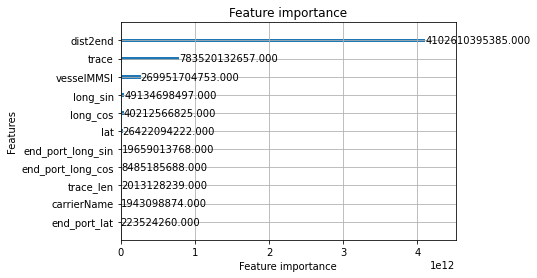

In [27]:
%time train_pred,test_pred = run_lgb_kfold(train_x,train_y/3600,test_x,params1,features,cat_cols=cat_cols)

fold: 1


d:\tools\python\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
d:\tools\python\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
d:\tools\python\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['carrierName', 'trace', 'vesselMMSI']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds
[20]	valid_0's l2: 10573.1	valid_0's l1: 61.5698
[40]	valid_0's l2: 7211.57	valid_0's l1: 45.5606
[60]	valid_0's l2: 6911.72	valid_0's l1: 44.141
[80]	valid_0's l2: 6847.59	valid_0's l1: 43.7018
[100]	valid_0's l2: 6825.38	valid_0's l1: 43.6064
[120]	valid_0's l2: 6800.93	valid_0's l1: 43.4473
[140]	valid_0's l2: 6789.54	valid_0's l1: 43.3578
[160]	valid_0's l2: 6761.07	valid_0's l1: 43.2001
[180]	valid_0's l2: 6744.39	valid_0's l1: 43.1115
[200]	valid_0's l2: 6723.53	valid_0's l1: 43.0209
[220]	valid_0's l2: 6716.24	valid_0's l1: 42.9717
[240]	valid_0's l2: 6694.67	valid_0's l1: 42.8677
[260]	valid_0's l2: 6685.33	valid_0's l1: 42.7741
[280]	valid_0's l2: 6675.57	valid_0's l1: 42.7289
[300]	valid_0's l2: 6669.98	valid_0's l1: 42.6678
[320]	valid_0's l2: 6663.51	valid_0's l1: 42.6236
[340]	valid_0's l2: 6636.73	valid_0's l1: 42.4998
[360]	valid_0's l2: 6631.08	valid_0's l1: 42.4498
[380]	valid_0's l2: 6631.78	valid_0's l1: 42

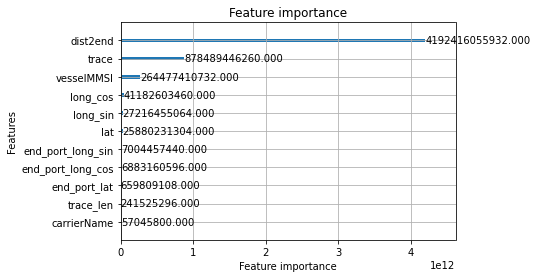

In [35]:
%time train_pred,test_pred = run_lgb_kfold(train_x,train_y/3600,test_x,params1,features,cat_cols=cat_cols)

In [36]:
test_order_pred = test_x[['loadingOrder','timestamp','dist2end']]
test_order_pred['pred'] = test_pred
test_order_pred['ETA'] = test_order_pred['timestamp'] + test_order_pred['pred'].apply(lambda x:pd.Timedelta(hours=x))

d:\tools\python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
d:\tools\python\lib\site-packages\pandas\core\arrays\datetimelike.py:1268: PerformanceWarning: Adding/subtracting array of DateOffsets to TimedeltaArray not vectorized
  PerformanceWarning,
d:\tools\python\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
tmp_result = test_order_pred.groupby(by='loadingOrder')['ETA'].apply(lambda x:x.mean())[GA_test_order_dict.keys()]
score = 0
for o in GA_test_order_dict:
    score += ((tmp_result[o]-pd.to_datetime(GA_test_order_dict[o])).total_seconds()/3600)**2
print(score/len(GA_test_order_dict))
print(tmp_result,GA_test_order_dict)

3039.15530649207
loadingOrder
VT660611547333   2020-03-14 21:40:38.245221376
BR663094574600   2020-06-01 21:11:02.216062720
KD265061648304   2020-06-01 09:39:42.242736128
TI854412328664   2020-06-01 05:03:16.102737920
JE319829909965   2020-01-05 06:33:10.183897600
PK422158256377   2020-06-01 19:11:47.404839680
NO206755451873   2020-06-02 23:30:12.315956224
NI245305422658   2020-06-01 21:27:56.067350272
NH835931693561   2020-03-14 16:48:05.656686080
LR291426429726   2020-05-05 10:19:48.300037888
KL671073399431   2020-06-02 07:35:57.761838080
DH829189593918   2020-01-16 22:51:40.710400768
Name: ETA, dtype: datetime64[ns] {'VT660611547333': '2020-03-13 23:39:28', 'BR663094574600': '2020-06-01 21:08:03', 'KD265061648304': '2020-06-01 14:31:43', 'TI854412328664': '2020-06-01 05:29:08', 'JE319829909965': '2020-01-04 17:34:28', 'PK422158256377': '2020-06-01 23:58:15', 'NO206755451873': '2020-06-01 00:05:50', 'NI245305422658': '2020-06-01 00:06:57', 'NH835931693561': '2020-03-13 23:39:28', 'LR

In [98]:
tmp_result = test_order_pred.groupby(by='loadingOrder')['ETA'].apply(lambda x:x.mean())[GA_test_order_dict.keys()]
score = 0
for o in GA_test_order_dict:
    score += ((tmp_result[o]-pd.to_datetime(GA_test_order_dict[o])).total_seconds()/3600)**2
print(score/len(GA_test_order_dict))
print(tmp_result,GA_test_order_dict)

4886.379341950278
loadingOrder
VT660611547333   2020-03-15 00:34:11.942089472
BR663094574600   2020-06-01 23:24:22.988579072
KD265061648304   2020-06-01 13:40:43.116424448
TI854412328664   2020-06-01 05:48:49.163471872
JE319829909965   2020-01-05 00:28:19.836328448
PK422158256377   2020-06-01 19:10:54.564691968
NO206755451873   2020-06-02 22:52:50.970330112
NI245305422658   2020-06-01 21:46:28.427283200
NH835931693561   2020-03-14 20:30:40.656332032
LR291426429726   2020-05-07 14:26:39.099383040
KL671073399431   2020-06-02 18:10:45.923020800
DH829189593918   2020-01-16 23:52:14.374692096
Name: ETA, dtype: datetime64[ns] {'VT660611547333': '2020-03-13 23:39:28', 'BR663094574600': '2020-06-01 21:08:03', 'KD265061648304': '2020-06-01 14:31:43', 'TI854412328664': '2020-06-01 05:29:08', 'JE319829909965': '2020-01-04 17:34:28', 'PK422158256377': '2020-06-01 23:58:15', 'NO206755451873': '2020-06-01 00:05:50', 'NI245305422658': '2020-06-01 00:06:57', 'NH835931693561': '2020-03-13 23:39:28', 'L

In [38]:
result = test_order_pred.groupby(by='loadingOrder')['ETA'].apply(lambda x:x.mean())

# 附上正确答案
for o in GA_test_order_dict:
    result[o] = pd.to_datetime(GA_test_order_dict[o])

result = pd.merge(pd.read_csv('data/R2 ATest 0711.csv'),result,how='left',on='loadingOrder')
result['ETA'] = result['ETA'].apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
result['creatDate'] = pd.datetime.now().strftime('%Y/%m/%d  %H:%M:%S')

result = result[['loadingOrder', 'timestamp', 'longitude', 'latitude', 'carrierName', 'vesselMMSI', 'onboardDate', 'ETA', 'creatDate']]

d:\tools\python\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if __name__ == '__main__':


In [39]:
now = datetime.datetime.now()
result.to_csv('result/result_{0}-{1}-{2}_{3}-{4}.csv'.format(now.year,now.month,now.day,now.hour,now.minute), index=False)
result

,loadingOrder,timestamp,longitude,latitude,carrierName,vesselMMSI,onboardDate,ETA,creatDate
0,QM149151037282,2019-01-11T04:18:28.000Z,114.337167,22.556333,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/25 14:39:19,2020/07/19 21:31:20
1,QM149151037282,2019-01-11T04:39:08.000Z,114.426632,22.508475,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/25 14:39:19,2020/07/19 21:31:20
2,QM149151037282,2019-01-11T06:05:48.000Z,114.418000,22.182000,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/25 14:39:19,2020/07/19 21:31:20
3,QM149151037282,2019-01-11T08:48:28.000Z,114.101650,22.314968,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/25 14:39:19,2020/07/19 21:31:20
4,QM149151037282,2019-01-11T09:50:58.000Z,114.123500,22.324167,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/25 14:39:19,2020/07/19 21:31:20
...,...,...,...,...,...,...,...,...,...
77649,RA164708092311,2020-06-22T23:21:24.000Z,113.607726,18.704520,OYSCFP,Y1808674695,2020/06/22 09:41:22,2020/06/26 03:20:32,2020/07/19 21:31:20
77650,RA164708092311,2020-06-22T23:40:51.000Z,113.577220,18.601798,OYSCFP,Y1808674695,2020/06/22 09:41:22,2020/06/26 03:20:32,2020/07/19 21:31:20
77651,RA164708092311,2020-06-22T23:42:43.000Z,113.577220,18.601798,OYSCFP,Y1808674695,2020/06/22 09:41:22,2020/06/26 03:20:32,2020/07/19 21:31:20
77652,RA164708092311,2020-06-22T23:51:23.000Z,113.562748,18.547645,OYSCFP,Y1808674695,2020/06/22 09:41:22,2020/06/26 03:20:32,2020/07/19 21:31:20


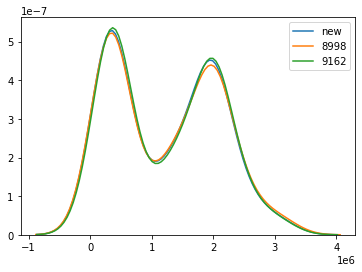

In [41]:
def cal_label(df):
    onboardDate = df.groupby('loadingOrder')['onboardDate'].agg(mmax='max').reset_index()
    ETA=df.groupby('loadingOrder')['ETA'].agg(mmax='max').reset_index()
    return (pd.to_datetime(ETA['mmax'])-pd.to_datetime(onboardDate['mmax'])).dt.total_seconds()

new=cal_label(result)
sns.kdeplot(new,label='new')

sns.kdeplot(cal_label(pd.read_csv('result/result_2020-7-19_21-17.csv')),label='8998')
sns.kdeplot(cal_label(pd.read_csv('result/result_2020-7-18_22-7.csv')),label='9162')

In [58]:
# 打标
all_ft['is_test'] = 0
all_ft.loc[all_ft.label.isnull(), 'is_test'] = 1
all_ft

,loadingOrder,carrierName,timestamp,vesselMMSI,trace,trace_len,dist2end,long_sin,long_cos,lat,end_port_long_sin,end_port_long_cos,end_port_lat,label,is_test
0,AA191175561416,12,2019-01-28 16:12:59+00:00,1021,345,2,13785.268122,0.911688,-0.410884,0.393939,-0.968992,-0.247093,0.333113,2253146.0,0
1,AA191175561416,12,2019-01-28 16:22:38+00:00,1021,345,2,13785.258647,0.911687,-0.410885,0.393940,-0.968992,-0.247093,0.333113,2252567.0,0
2,AA191175561416,12,2019-01-28 16:30:55+00:00,1021,345,2,13785.205371,0.911685,-0.410889,0.393948,-0.968992,-0.247093,0.333113,2252070.0,0
3,AA191175561416,12,2019-01-28 16:37:35+00:00,1021,345,2,13785.235477,0.911688,-0.410884,0.393946,-0.968992,-0.247093,0.333113,2251670.0,0
4,AA191175561416,12,2019-01-28 16:45:56+00:00,1021,345,2,13785.213197,0.911686,-0.410888,0.393947,-0.968992,-0.247093,0.333113,2251169.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20124157,ZZ318732594946,12,2020-03-19 14:55:28,108,345,2,13090.548586,0.857936,-0.513756,0.439615,-0.968992,-0.247093,0.333113,NaN,1
20124158,ZZ318732594946,12,2020-03-19 15:07:58,108,345,2,13083.315253,0.857532,-0.514430,0.440527,-0.968992,-0.247093,0.333113,NaN,1
20124159,ZZ318732594946,12,2020-03-19 15:11:08,108,345,2,13081.487117,0.857430,-0.514600,0.440758,-0.968992,-0.247093,0.333113,NaN,1
20124160,ZZ318732594946,12,2020-03-19 15:11:58,108,345,2,13081.028900,0.857405,-0.514643,0.440816,-0.968992,-0.247093,0.333113,NaN,1


Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.993655
[100]	valid_0's auc: 0.997165
[150]	valid_0's auc: 0.998427
[200]	valid_0's auc: 0.998914
[250]	valid_0's auc: 0.999147
[300]	valid_0's auc: 0.999276
[350]	valid_0's auc: 0.999366
[400]	valid_0's auc: 0.999415
[450]	valid_0's auc: 0.999456
[500]	valid_0's auc: 0.999478
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.999478
AUC:  0.9994778965678971
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.995172
[100]	valid_0's auc: 0.997902
[150]	valid_0's auc: 0.998801
[200]	valid_0's auc: 0.999105
[250]	valid_0's auc: 0.999286
[300]	valid_0's auc: 0.999372
[350]	valid_0's auc: 0.999424
[400]	valid_0's auc: 0.999461
[450]	valid_0's auc: 0.99949
[500]	valid_0's auc: 0.999512
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.999512
AUC:  0.9995115338639108
Training until validation scores don't improve for 50 rounds
[50]	valid_0's

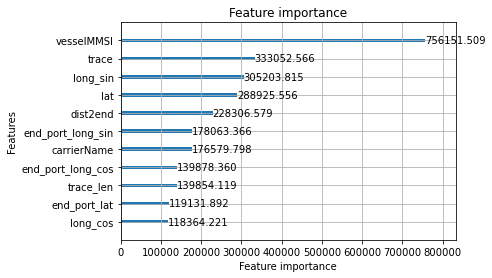

In [60]:
# 对抗验证模型构建及CV
def build_model_adv(train, features, label, seed=666, is_shuffle=True):
    train_pred = np.zeros((train.shape[0], ))
    n_splits = 3
    eval_score = 0
    # Kfold
    fold = StratifiedKFold(n_splits=n_splits, shuffle=is_shuffle, random_state=seed)
    kf_way = fold.split(train[features], train[label])
    # params
    params = {
            'boosting_type': 'gbdt',   # 传统梯度提升树类型
            'max_depth': 7,  # 树的最大深度，减少可降低过拟合
            'num_leaves': 31, # 叶子数量，取值应 <= 2 ^（max_depth）， 超过此值容易导致过拟合
            'objective': 'binary',  # binary用作二分类，regression用于回归，multiclass用于多分类
            'metric': 'auc',  # 衡量指标，可选有cross_entropy, binary_logloss,auc等
            'learning_rate': 0.1,
            'min_data_in_leaf':20,  # 叶子具有的最小记录数，默认为20，设置较大能减少树的深度，但有可能导致欠拟合
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            #'bagging_freq': 20,
            'reg_alpha': 3.77, 
            'reg_lambda': 5.86,
}
    # train
    for n_fold, (train_idx, valid_idx) in enumerate(kf_way, start=1):
        train_x, train_y = train[features].iloc[train_idx], train[label].iloc[train_idx]
        valid_x, valid_y = train[features].iloc[valid_idx], train[label].iloc[valid_idx]
        # 数据加载
        n_train = lgb.Dataset(train_x, label=train_y)
        n_valid = lgb.Dataset(valid_x, label=valid_y)
        
        eval_results = {}
        
        clf = lgb.train(
            params=params,
            train_set=n_train,
            num_boost_round=500,
            valid_sets=[n_valid],
            evals_result = eval_results, 
            early_stopping_rounds=50,
            verbose_eval=50,
        )
        train_pred[valid_idx] += clf.predict(valid_x, num_iteration=clf.best_iteration)
        print("AUC: ", eval_results['valid_0']['auc'][clf.best_iteration-1])
        eval_score += eval_results['valid_0']['auc'][clf.best_iteration-1]
        
    # Feature importance
    print("AUC_mean: ", round(eval_score/n_splits,6))  
    
    lgb.plot_importance(clf, max_num_features = 20, importance_type = 'gain')
    train['is_test_predict'] = train_pred
    return train

# 预测是测试集的概率
data2 = build_model_adv(all_ft, features, 'is_test', is_shuffle=True)

In [61]:
train = data2[data2['is_test']==0].sort_values(by=['is_test_predict'], ascending=False).reset_index(drop=True)
test = data2[data2['is_test']==1].reset_index(drop=True)
valid = train[:round(train.shape[0]/10)]
train = train[round(train.shape[0]/10):]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.35461e+11	valid_0's mse_score: 10452.2
[200]	valid_0's l2: 5.47161e+10	valid_0's mse_score: 4221.92
[300]	valid_0's l2: 3.89707e+10	valid_0's mse_score: 3007
[400]	valid_0's l2: 3.36461e+10	valid_0's mse_score: 2596.15
[500]	valid_0's l2: 3.098e+10	valid_0's mse_score: 2390.44
[600]	valid_0's l2: 2.89751e+10	valid_0's mse_score: 2235.74
[700]	valid_0's l2: 2.74044e+10	valid_0's mse_score: 2114.53
[800]	valid_0's l2: 2.61146e+10	valid_0's mse_score: 2015.02
[900]	valid_0's l2: 2.52532e+10	valid_0's mse_score: 1948.55
[1000]	valid_0's l2: 2.43656e+10	valid_0's mse_score: 1880.06
[1100]	valid_0's l2: 2.33789e+10	valid_0's mse_score: 1803.93
[1200]	valid_0's l2: 2.25253e+10	valid_0's mse_score: 1738.07
[1300]	valid_0's l2: 2.18948e+10	valid_0's mse_score: 1689.41
[1400]	valid_0's l2: 2.13745e+10	valid_0's mse_score: 1649.27
[1500]	valid_0's l2: 2.09378e+10	valid_0's mse_score: 1615.57
[1600]	valid_0's l2: 2

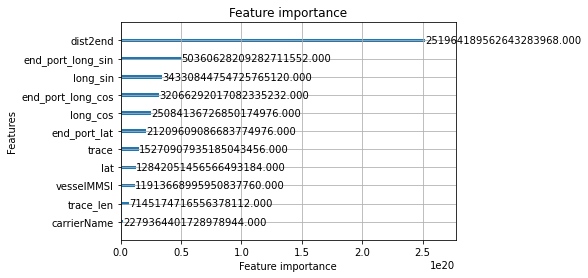

In [62]:
def mse_score_eval(preds, valid):
    labels = valid.get_label()
    scores = mean_squared_error(y_true=labels/3600, y_pred=preds/3600)
    return 'mse_score', scores, False

def build_model_once(train, valid, test, features, label, seed=1080, is_shuffle=True):
    params = {
        'learning_rate': 0.01,
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'num_leaves': 36,
        'feature_fraction': 0.6,
        'bagging_fraction': 0.7,
        'bagging_freq': 6,
        'seed': 8,
        'bagging_seed': 1,
        'feature_fraction_seed': 7,
        'min_data_in_leaf': 20,
        'nthread': 8,
        'verbose': 1,
        'device':'cpu'
    }
    
    # 数据加载
    n_train = lgb.Dataset(train[features], label=train[label])
    n_valid = lgb.Dataset(valid[features], label=valid[label])

    clf = lgb.train(
        params=params,
        train_set=n_train,
        num_boost_round=3000,
        valid_sets=[n_valid],
        early_stopping_rounds=100,
        verbose_eval=100,
        feval=mse_score_eval
    )
    # 打印特征重要度
    lgb.plot_importance(clf, max_num_features = 20, importance_type = 'gain')
    
    test['label'] = clf.predict(test[features], num_iteration=clf.best_iteration)
    
    # print('oof MSE: ',mean_squared_error(train[label]/3600,train_pred/3600))
    print('test_label均值',np.mean(test[label]/3600))
    print('train_label均值',np.mean(train[label]/3600))
    return test[['loadingOrder', 'label']]

# baseline
result = build_model_once(train, valid, test, features, 'label', is_shuffle=True)

In [63]:
result

,loadingOrder,label
0,AC437723355280,3.009428e+06
1,AC437723355280,3.009428e+06
2,AC437723355280,3.008645e+06
3,AC437723355280,3.008645e+06
4,AC437723355280,3.008645e+06
...,...,...
59744,ZZ318732594946,1.892182e+06
59745,ZZ318732594946,1.892182e+06
59746,ZZ318732594946,1.892182e+06
59747,ZZ318732594946,1.892182e+06


In [64]:
test_x

,loadingOrder,carrierName,timestamp,vesselMMSI,trace,trace_len,dist2end,long_sin,long_cos,lat,end_port_long_sin,end_port_long_cos,end_port_lat,label
0,AC437723355280,8,2019-06-23 02:53:18,268,106,2,18733.205153,0.914283,-0.405075,0.390665,-0.949113,0.314937,-0.576497,NaN
1,AC437723355280,8,2019-06-23 03:01:28,268,106,2,18729.917630,0.914127,-0.405427,0.390258,-0.949113,0.314937,-0.576497,NaN
2,AC437723355280,8,2019-06-23 03:16:38,268,106,2,18725.932620,0.913704,-0.406381,0.389998,-0.949113,0.314937,-0.576497,NaN
3,AC437723355280,8,2019-06-23 03:17:08,268,106,2,18725.832372,0.913685,-0.406422,0.389999,-0.949113,0.314937,-0.576497,NaN
4,AC437723355280,8,2019-06-23 03:18:08,268,106,2,18725.677367,0.913658,-0.406483,0.390000,-0.949113,0.314937,-0.576497,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59744,ZZ318732594946,12,2020-03-19 14:55:28,108,345,2,13090.548586,0.857936,-0.513756,0.439615,-0.968992,-0.247093,0.333113,NaN
59745,ZZ318732594946,12,2020-03-19 15:07:58,108,345,2,13083.315253,0.857532,-0.514430,0.440527,-0.968992,-0.247093,0.333113,NaN
59746,ZZ318732594946,12,2020-03-19 15:11:08,108,345,2,13081.487117,0.857430,-0.514600,0.440758,-0.968992,-0.247093,0.333113,NaN
59747,ZZ318732594946,12,2020-03-19 15:11:58,108,345,2,13081.028900,0.857405,-0.514643,0.440816,-0.968992,-0.247093,0.333113,NaN


In [75]:
test_order_pred = test_x[['loadingOrder','timestamp','dist2end']]
test_order_pred['pred'] = result['label']
test_order_pred['ETA'] = test_order_pred['timestamp'] + test_order_pred['pred'].apply(lambda x:pd.Timedelta(seconds=x))
result2 = test_order_pred.groupby(by='loadingOrder')['ETA'].apply(lambda x:x.mean())


d:\tools\python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
d:\tools\python\lib\site-packages\pandas\core\arrays\datetimelike.py:1268: PerformanceWarning: Adding/subtracting array of DateOffsets to TimedeltaArray not vectorized
  PerformanceWarning,
d:\tools\python\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [76]:

# 附上正确答案
for o in GA_test_order_dict:
    result2[o] = pd.to_datetime(GA_test_order_dict[o])

result2 = pd.merge(pd.read_csv('data/R2 ATest 0711.csv'),result2,how='left',on='loadingOrder')
result2['ETA'] = result2['ETA'].apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
result2['creatDate'] = pd.datetime.now().strftime('%Y/%m/%d  %H:%M:%S')

result2 = result2[['loadingOrder', 'timestamp', 'longitude', 'latitude', 'carrierName', 'vesselMMSI', 'onboardDate', 'ETA', 'creatDate']]

d:\tools\python\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


In [78]:
now = datetime.datetime.now()
result2.to_csv('result/result_{0}-{1}-{2}_{3}-{4}.csv'.format(now.year,now.month,now.day,now.hour,now.minute), index=False)
result2

,loadingOrder,timestamp,longitude,latitude,carrierName,vesselMMSI,onboardDate,ETA,creatDate
0,QM149151037282,2019-01-11T04:18:28.000Z,114.337167,22.556333,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/26 13:08:24,2020/07/19 22:48:24
1,QM149151037282,2019-01-11T04:39:08.000Z,114.426632,22.508475,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/26 13:08:24,2020/07/19 22:48:24
2,QM149151037282,2019-01-11T06:05:48.000Z,114.418000,22.182000,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/26 13:08:24,2020/07/19 22:48:24
3,QM149151037282,2019-01-11T08:48:28.000Z,114.101650,22.314968,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/26 13:08:24,2020/07/19 22:48:24
4,QM149151037282,2019-01-11T09:50:58.000Z,114.123500,22.324167,UQCRKD,Q4197827697,2019/01/11 04:18:28,2019/01/26 13:08:24,2020/07/19 22:48:24
...,...,...,...,...,...,...,...,...,...
77649,RA164708092311,2020-06-22T23:21:24.000Z,113.607726,18.704520,OYSCFP,Y1808674695,2020/06/22 09:41:22,2020/06/26 11:46:18,2020/07/19 22:48:24
77650,RA164708092311,2020-06-22T23:40:51.000Z,113.577220,18.601798,OYSCFP,Y1808674695,2020/06/22 09:41:22,2020/06/26 11:46:18,2020/07/19 22:48:24
77651,RA164708092311,2020-06-22T23:42:43.000Z,113.577220,18.601798,OYSCFP,Y1808674695,2020/06/22 09:41:22,2020/06/26 11:46:18,2020/07/19 22:48:24
77652,RA164708092311,2020-06-22T23:51:23.000Z,113.562748,18.547645,OYSCFP,Y1808674695,2020/06/22 09:41:22,2020/06/26 11:46:18,2020/07/19 22:48:24


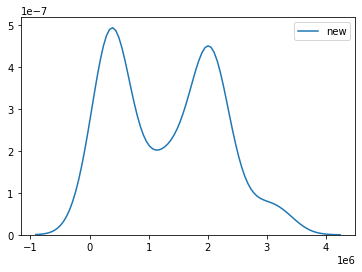

In [85]:
def cal_label(df):
    onboardDate = df.groupby('loadingOrder')['onboardDate'].agg(mmax='max').reset_index()
    ETA=df.groupby('loadingOrder')['ETA'].agg(mmax='max').reset_index()
    return (pd.to_datetime(ETA['mmax'])-pd.to_datetime(onboardDate['mmax'])).dt.total_seconds()

new=cal_label(result2)
sns.kdeplot(new,label='new')

# sns.kdeplot(cal_label(pd.read_csv('result/result_2020-7-19_21-17.csv')),label='8998')

In [88]:
all_ft

,loadingOrder,carrierName,timestamp,vesselMMSI,trace,trace_len,dist2end,long_sin,long_cos,lat,end_port_long_sin,end_port_long_cos,end_port_lat,label,is_test,is_test_predict
0,AA191175561416,12,2019-01-28 16:12:59+00:00,1021,345,2,13785.268122,0.911688,-0.410884,0.393939,-0.968992,-0.247093,0.333113,2253146.0,0,0.062879
1,AA191175561416,12,2019-01-28 16:22:38+00:00,1021,345,2,13785.258647,0.911687,-0.410885,0.393940,-0.968992,-0.247093,0.333113,2252567.0,0,0.062879
2,AA191175561416,12,2019-01-28 16:30:55+00:00,1021,345,2,13785.205371,0.911685,-0.410889,0.393948,-0.968992,-0.247093,0.333113,2252070.0,0,0.074358
3,AA191175561416,12,2019-01-28 16:37:35+00:00,1021,345,2,13785.235477,0.911688,-0.410884,0.393946,-0.968992,-0.247093,0.333113,2251670.0,0,0.062879
4,AA191175561416,12,2019-01-28 16:45:56+00:00,1021,345,2,13785.213197,0.911686,-0.410888,0.393947,-0.968992,-0.247093,0.333113,2251169.0,0,0.074358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20124157,ZZ318732594946,12,2020-03-19 14:55:28,108,345,2,13090.548586,0.857936,-0.513756,0.439615,-0.968992,-0.247093,0.333113,NaN,1,0.983186
20124158,ZZ318732594946,12,2020-03-19 15:07:58,108,345,2,13083.315253,0.857532,-0.514430,0.440527,-0.968992,-0.247093,0.333113,NaN,1,0.949672
20124159,ZZ318732594946,12,2020-03-19 15:11:08,108,345,2,13081.487117,0.857430,-0.514600,0.440758,-0.968992,-0.247093,0.333113,NaN,1,0.949672
20124160,ZZ318732594946,12,2020-03-19 15:11:58,108,345,2,13081.028900,0.857405,-0.514643,0.440816,-0.968992,-0.247093,0.333113,NaN,1,0.949672
